In [1]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Goal
The May edition of the 2022 Tabular Playground series binary classification problem that includes a number of different feature interactions. This competition is an opportunity to explore various methods for identifying and exploiting these feature interactions.

In [2]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')
sub = pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')

print(train.shape)
print(test.shape)
print(sub.shape)

(900000, 33)
(700000, 32)
(700000, 2)


In [3]:
train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


# EDA

In [4]:
def eda(df):
    summary = pd.DataFrame()
    summary['miss'] = df.isnull().sum()
    summary['level'] = df.nunique()
    summary['dtype'] = df.dtypes
    return summary

edatrain = eda(train)
edatrain.T

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
level,900000,900000,900000,900000,900000,900000,900000,900000,16,16,15,15,14,16,13,14,15,16,14,14,900000,900000,900000,900000,900000,900000,900000,900000,741354,900000,2,3,2
dtype,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,int64,int64,int64


In [5]:
eda(test).T

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
level,700000,700000,700000,700000,700000,700000,700000,700000,16,14,16,16,15,16,14,13,14,14,14,14,700000,700000,700000,700000,700000,700000,700000,700000,598482,700000,2,3
dtype,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,int64,int64


In [6]:
train.target.value_counts()

0    462161
1    437839
Name: target, dtype: int64

# Correlation Analysis

In [7]:
train.corr()['target'].abs().sort_values(ascending = False)

target    1.000000
f_21      0.130887
f_19      0.087698
f_24      0.086350
f_23      0.081206
f_11      0.078525
f_09      0.067909
f_22      0.065554
f_26      0.058915
f_00      0.055274
f_01      0.055011
f_29      0.051306
f_15      0.043297
f_16      0.037303
f_20      0.036599
f_08      0.035829
f_28      0.035824
f_10      0.035420
f_13      0.034092
f_05      0.033048
f_25      0.032836
f_02      0.031814
f_30      0.020721
f_14      0.017588
f_18      0.010781
f_07      0.005257
f_17      0.001832
f_06      0.000965
f_12      0.000962
f_03      0.000192
id        0.000184
f_04      0.000159
Name: target, dtype: float64

# Pre-processing

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
scaler = StandardScaler()

# FE

In [9]:
def fe(df):
    
    for i in tqdm(range(10)):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')

    df["unique_characters"] = df['f_27'].apply(lambda s: len(set(s)))
    #based on https://www.kaggle.com/code/wti200/analysing-interactions-with-shap

    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    
    
#     ######################### Freq encoding
#     cat_col = ['ch'+str(i) for i in range(0,10)]+ ['f_'+str(i) for i in range(10,19)] + ['f_07', 'f_08','f_09','f_29','f_30']  
   
    
    
#     for col in cat_col:    
#         fq_encode = df[col].value_counts(dropna= True, normalize = True).to_dict()   
#         df[col+'_fq_enc'] = df[col].map(fq_encode)
    
    return df



train = fe(train)

test = fe(test)

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


In [10]:
X_train = train.drop(['id','target','f_27'], axis = 1)
y_train = train.target

X_test = test.drop(['id','f_27'], axis = 1)

print(X_train.shape)
print(X_test.shape)

(900000, 44)
(700000, 44)


In [11]:
X_train.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,unique_characters,i_02_21,i_05_22,i_00_01_26
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,67.609153,0,0,0,1,0,1,3,0,3,1,0,1,3,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,377.096415,0,0,0,2,0,2,2,0,3,2,4,1,5,0,0,0
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,-195.599702,0,2,0,0,0,4,0,1,2,10,0,3,6,0,0,0
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,210.826205,0,0,1,3,1,1,0,0,2,1,2,1,4,0,0,0
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,-217.211798,0,1,1,3,1,2,1,1,2,7,5,4,6,0,0,1


 https://www.kaggle.com/competitions/tabular-playground-series-may-2022/discussion/323766

# NN Model

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, InputLayer, Add
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import metrics, regularizers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import random

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-05-17 18:46:41.441432: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-17 18:46:41.441547: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-17 18:46:46.192454: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-17 18:46:46.195606: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-17 18:46:46.195643: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 18:46:46.195675: I tensorflow/stream_executor/cuda/cud

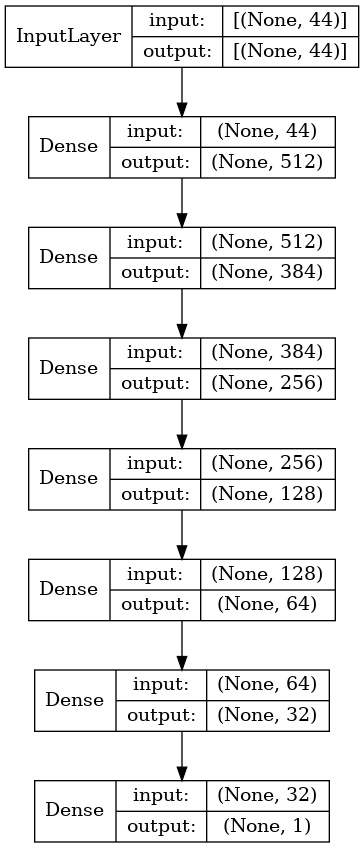

In [13]:
def nn_model():
    
    x_input = Input(shape=(X_train.shape[1]))
    x = Dense(512, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x_input)
    x = Dense(384, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x)
    x = Dense(128, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x)
    x = Dense(32, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=x_input, outputs=output)
    
    return model

model = nn_model()
plot_model(model, show_layer_names=False, show_shapes=True)

In [14]:
BATCH_SIZE = 4096

X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test))

scores_folds = []
test_pred = np.zeros(len(test))

cv = KFold(n_splits=5,random_state=42, shuffle=True)

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    
    print("\n**********Fold {}***********".format(fold+1))
    
    X_tr, y_tr = X_train.iloc[train_idx,:], y_train[train_idx]
    X_val, y_val = X_train.iloc[val_idx,:], y_train[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}".format(
        X_tr.shape, y_tr.shape, X_val.shape, y_val.shape))
    
    with tpu_strategy.scope():

        model = nn_model()
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                      loss='BinaryCrossentropy',
                      metrics=['AUC'])
        
        lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5,  patience=3, verbose=True)
        es = EarlyStopping(monitor='val_auc', mode='max', patience=5, 
                           restore_best_weights=True, verbose=True)
        
        model.fit(X_tr, y_tr,
                  validation_data=(X_val, y_val), 
                  epochs=50, batch_size=4096, 
                  callbacks=[es,lr], verbose=True, shuffle=True)
        
        preds = model.predict(X_val).reshape(1,-1)[0]
        
        score = round(roc_auc_score(y_val,preds),5)
        print('Fold {}: AUC {}'.format(fold+1,  score))
        
        scores_folds.append(score)
     
        test_pred += model.predict(X_test, batch_size = BATCH_SIZE).reshape(1,-1)[0]/cv.n_splits
      
    del X_tr, y_tr, X_val, y_val
    gc.collect() 
    
  


**********Fold 1***********
Train shape: (720000, 44), (720000,), Valid shape: (180000, 44), (180000,)
Epoch 1/50
176/176 [==============================] - 10s 34ms/step - loss: 0.3537 - auc: 0.9227 - val_loss: 0.1444 - val_auc: 0.9902
Epoch 2/50
176/176 [==============================] - 3s 17ms/step - loss: 0.1250 - auc: 0.9929 - val_loss: 0.1106 - val_auc: 0.9947
Epoch 3/50
176/176 [==============================] - 3s 18ms/step - loss: 0.1055 - auc: 0.9953 - val_loss: 0.1017 - val_auc: 0.9956
Epoch 4/50
176/176 [==============================] - 3s 17ms/step - loss: 0.0963 - auc: 0.9962 - val_loss: 0.0990 - val_auc: 0.9958

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 5/50
176/176 [==============================] - 3s 17ms/step - loss: 0.0836 - auc: 0.9972 - val_loss: 0.0857 - val_auc: 0.9969
Epoch 6/50
176/176 [==============================] - 3s 18ms/step - loss: 0.0774 - auc: 0.9975 - val_loss: 0.0852 - val_auc: 0.9968
Epoch 7/50
176/17

In [15]:
print(scores_folds)  

[0.99749, 0.99759, 0.99766, 0.99751, 0.99754]


# Submission

In [16]:
sub['target'] = test_pred

sub.to_csv('sub_nn.csv', index = False)

sub.describe()


,id,target
count,7.000000e+05,700000.000000
mean,1.250000e+06,0.486785
std,2.020727e+05,0.481794
min,9.000000e+05,0.000000
25%,1.075000e+06,0.000149
50%,1.250000e+06,0.292585
75%,1.424999e+06,0.999818
max,1.599999e+06,1.000000


In [17]:
sub

,id,target
0,900000,0.999998
1,900001,0.999914
2,900002,0.000000
3,900003,0.000162
4,900004,0.998917
...,...,...
699995,1599995,0.603919
699996,1599996,0.999981
699997,1599997,0.026367
699998,1599998,0.000003
